In [24]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib
import os

# %matplotlib inline
%matplotlib notebook

In [25]:
#Loading the files to check how the objects selected changes with different conditions

ScoCen_Parallax_ProperMotion = Table.read('/disks/strw3/jvilla/Major_JorgeVilla/RNAAS/Data/ScoCen_Parallax_ProperMotion.csv', format = 'ascii', data_start = 0, fast_reader = True)
ScoCen_Parallax              = Table.read('/disks/strw3/jvilla/Major_JorgeVilla/RNAAS/Data/ScoCen_Parallax.csv', format = 'ascii', data_start = 0, fast_reader = True)

#Checking thenumber of stars retrieved per field

print('The number of stars if parallax/proper motion cuts are included is: %i'%len(ScoCen_Parallax_ProperMotion["source_id"]))
print('The number of stars if parallax cut is included is: %i'%len(ScoCen_Parallax["source_id"]))

The number of stars if parallax/proper motion cuts are included is: 58136
The number of stars if parallax cut is included is: 74870


In [26]:
#File to be analyzed

Data = ScoCen_Parallax

In [27]:
Mag      = np.subtract(Data['g_mag_abs'], 19.5)
Sample   = Data[np.where(Data['vis_period'] >= 6)]
U        = np.sqrt(Sample['unit_weight'])

Cleaned_Sample   = Sample[np.where( U < 1.44*np.maximum(1.0, np.exp(-0.2*Mag)))]

print('Original - More than 6 visibility')
print(len(Sample))

print('More than 6 visibility + Chi-square')
print(len(Cleaned_Sample)) 

Original - More than 6 visibility
74870
More than 6 visibility + Chi-square
74746


<IPython.core.display.Javascript object>


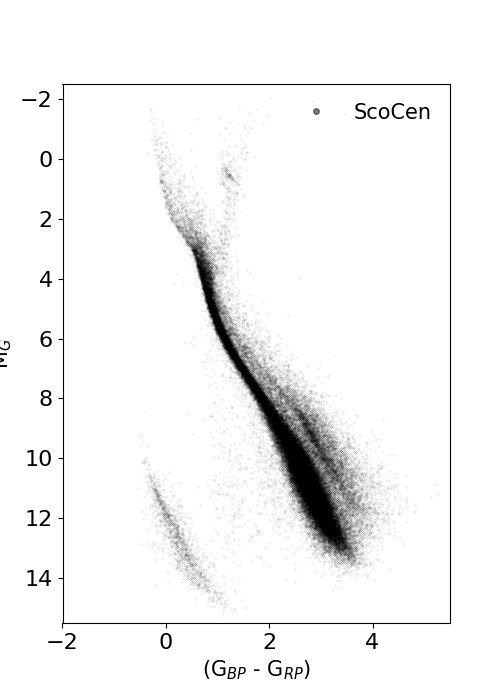

In [28]:
'''Click on the image below, from the bottom-right and keep on selecting counterclockwise
selecting the region of interest. When the user thinks the path is finally closed
go to the next block. The values selected with mouse will be stored in an 
array named Cleaned_Sample_Path and will be passed to the Path function which will
select the points inside the path created.'''

fig  = plt.figure(figsize = (5,7))
axA  = fig.add_subplot(111)
axA.plot(Cleaned_Sample['bp_rp'],Cleaned_Sample['g_mag_abs'], 'o', c = 'k', markersize = 0.1, alpha = 0.5)
axA.legend(['ScoCen'], \
           frameon = False, prop = {'size': 15}, markerscale = 40, loc = 'upper right')
axA.set_ylim(15.5,-2.5)
axA.set_xlim(-2, 5.5)
axA.set_ylabel(r"M$_{G}$", size = 15)
axA.set_xlabel(r"(G$_{BP}$ - G$_{RP}$)", size = 15)
axA.tick_params(axis = 'both', which = 'major', labelsize = 16)

Cleaned_Sample_Path = []

def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    print('x = %d, y = %d'%(ix, iy))

    global Cleaned_Sample_Path
    Cleaned_Sample_Path.append((ix, iy))

    if len(Cleaned_Sample_Path) == 50:
        fig.canvas.mpl_disconnect(cid)

    return Cleaned_Sample_Path

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [29]:
fig.canvas.mpl_disconnect(cid)

In [30]:
#Only pre-main sequence stars selection

'''Only pre-main sequence stars are selected using the Path defined above.
The coordinates in Ra and Dec, and also in l and b are stored to produce
a figure showing the distribution of these stars on the sky plane.'''

x_DR2 = np.array(Cleaned_Sample["bp_rp"])
y_DR2 = np.array(Cleaned_Sample["g_mag_abs"])

Cleaned_Sample_Codes = []
for i in range(len(Cleaned_Sample_Path)):
    if i == 0:
        Cleaned_Sample_Codes.append(1)
    if i != 0 and i != len(Cleaned_Sample_Path) - 1:
        Cleaned_Sample_Codes.append(2)
    if i == len(Cleaned_Sample_Path) - 1:
        Cleaned_Sample_Codes.append(79)

path_DR2         = Path(Cleaned_Sample_Path, Cleaned_Sample_Codes)

Points_DR2       = np.column_stack((x_DR2,y_DR2))
Sample_DR2 = []
RA_DR2     = []
DEC_DR2    = []
l_DR2      = []
b_DR2      = []
for i in range(len(Points_DR2)):
    if path_DR2.contains_point(Points_DR2[i].tolist()) == True:
        Sample_DR2.append(Points_DR2[i])
        RA_DR2.append(Cleaned_Sample["ra"][i])
        DEC_DR2.append(Cleaned_Sample["dec"][i])
        l_DR2.append(Cleaned_Sample["l"][i])
        b_DR2.append(Cleaned_Sample["b"][i]) 
Sample_DR2 = np.array(Sample_DR2)

In [31]:
%matplotlib inline

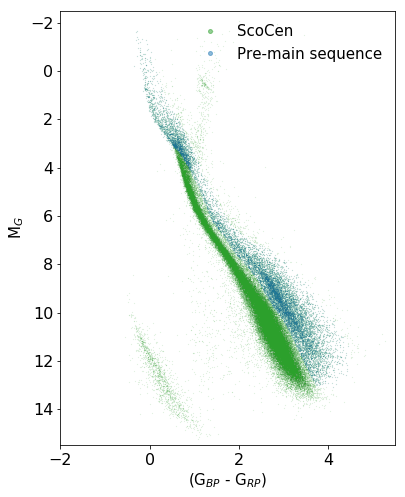

In [32]:
#Plotting

fig, ((axA)) = plt.subplots(figsize = (6,8), nrows = 1, ncols = 1, sharey = True)

axA.plot(Cleaned_Sample['bp_rp'], Cleaned_Sample['g_mag_abs'], 'o', c = 'C2', markersize = 0.1, alpha = 0.5)
axA.plot(Sample_DR2[:,0], Sample_DR2[:,1], 'o', c = 'C0', markersize = 0.1, alpha = 0.5)
axA.legend(['ScoCen', 'Pre-main sequence'], \
           frameon = False, prop = {'size': 15}, markerscale = 40, loc = 'upper right')
axA.set_ylim(15.5,-2.5)
axA.set_xlim(-2, 5.5)
axA.set_ylabel(r"M$_{G}$", size = 15)
axA.set_xlabel(r"(G$_{BP}$ - G$_{RP}$)", size = 15)
axA.tick_params(axis = 'both', which = 'major', labelsize = 16)

fig.subplots_adjust(wspace = 0)
# plt.savefig("ScoCen_CDM_Parallax.png", dpi = 300, bbox_inches = 'tight')

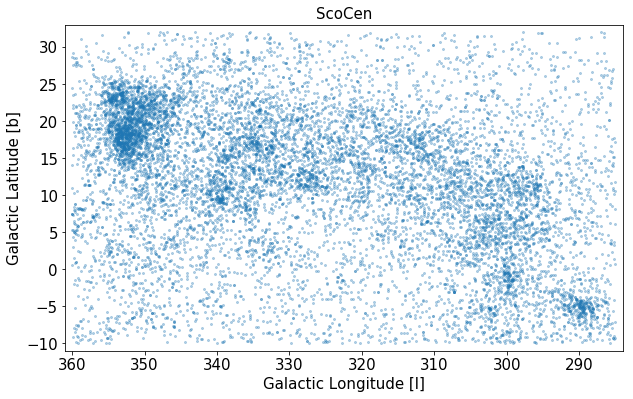

In [33]:
plt.figure(figsize = (10,6))
plt.plot(l_DR2, b_DR2, 'o', c = 'C0',markersize = 2.0, alpha = 0.3)
plt.xlim(361, 284)
plt.ylim(-11, 33)
plt.xlabel("Galactic Longitude [l]", size = 15)
plt.ylabel("Galactic Latitude [b]", size = 15)
plt.title('ScoCen', size = 15)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)

plt.savefig("ScoCen_Coordinates_Parallax.png", dpi = 300, bbox_inches = 'tight')

In [50]:
RA = np.append(RA_DR2, RA_DR2); DEC = np.append(DEC_DR2, DEC_DR2)

In [51]:
#Writing out RA and DEC for the final selection after Mamajek and Isochrones
np.savetxt('Coordinates_DR2_PreMainSequence.csv', np.c_[RA, DEC], fmt = ['%.15f','%.15f'], delimiter = ',')


In [34]:
os.system('mv *.png /disks/strw3/jvilla/Major_JorgeVilla/RNAAS/Figures')

0